In [ ]:
#https://github.com/dkk/DCGAN256/blob/master/Hand%20Generator.ipynb

In [29]:
%reset -f

In [30]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
print('Google Drive connected.')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive connected.


In [31]:
!nvidia-smi

Tue Jan 19 18:25:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W /  70W |  10857MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
import zipfile
import glob
import os
import time

import matplotlib.pyplot as plt
from PIL import Image 
from IPython import display
import imageio

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
# Hyperparametros

BATCH_SIZE = 128
TARGET_SIZE = (256, 256)

In [34]:
# Rutas
images_path = "/content/gdrive/MyDrive/GAN/imagenes_input"
out_images_path = '/content/gdrive/MyDrive/GAN/imagenes_output'
checkpoint_dir = '/content/gdrive/MyDrive/GAN/checkpoints'

real_image_paths = list(glob.glob(images_path + '/monet/*'))

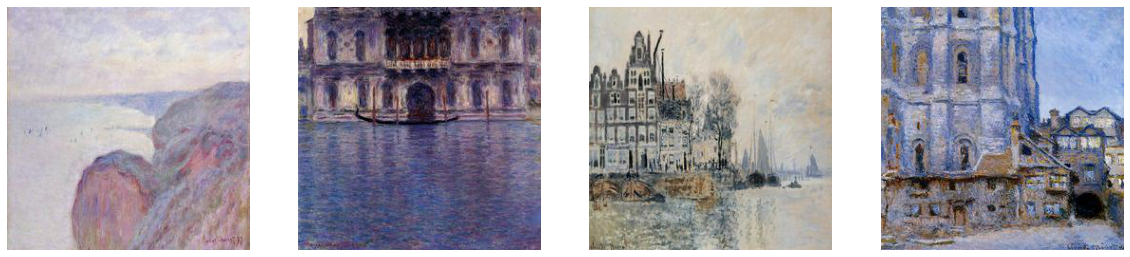

In [35]:
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(Image.open(real_image_paths[i]))
    plt.axis('off')

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# preprocessing function to change the rangevalue space of 
# the image to [-1, 1] as proposed by [8][9]
def changeRange(image):
    return [(i/128.0)-1 for i in image[:, :, :]]

# For more information see [5]
image_generator = ImageDataGenerator(
    preprocessing_function = changeRange,
    horizontal_flip = True,
    vertical_flip = True)

real_generator = image_generator.flow_from_directory(images_path,
                                                     batch_size = BATCH_SIZE,
                                                     shuffle = True,
                                                     target_size = TARGET_SIZE,
                                                     classes=["monet"])

Found 300 images belonging to 1 classes.


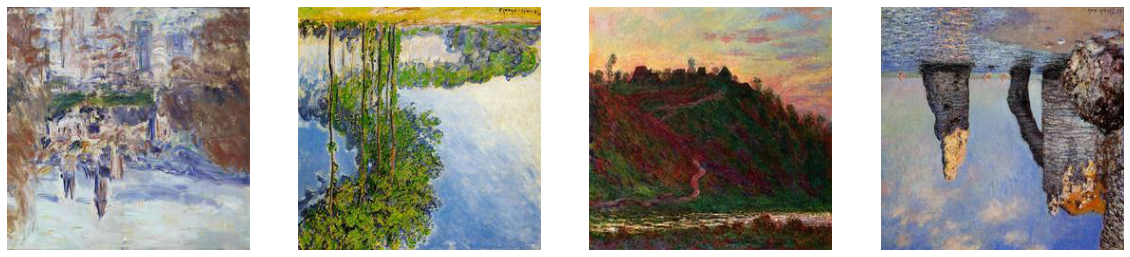

In [37]:
x,y = real_generator.next()
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow((x[i]+1)/2)
    plt.axis('off')

In [38]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
    assert model.output_shape == (None, 1, 1, 4096)
        
    model.add(layers.Conv2DTranspose(filters = 256, kernel_size = 4))
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 4, 4, 256)
    
    model.add(layers.Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 8, 8, 256)
    
    model.add(layers.Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 16, 16, 128)
    
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 32, 32, 64)
    
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 64, 64, 32)
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 128, 128, 16)
    
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 256, 256, 8)
    
    model.add(layers.Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 256, 256, 3)
    
    return model

In [39]:
# declares the generator
generator = generator_model()
#generator.summary()

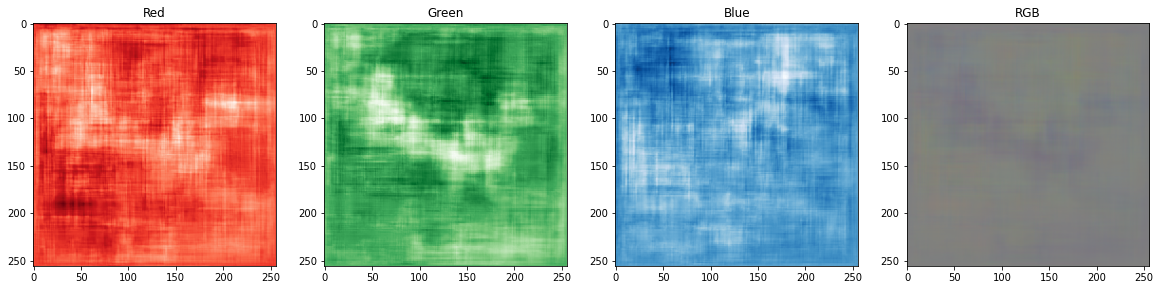

In [40]:
# Ejemplo de un generador sin entrenar

noise = tf.random.normal([1, 4096])
generated_image = generator(noise, training=False)

# show output of untrained generator
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1); plt.title("Red"); plt.imshow((generated_image[0, :, :, 0] + 1)/2, cmap='Reds')
plt.subplot(1, 4, 2); plt.title("Green"); plt.imshow((generated_image[0, :, :, 1] + 1)/2, cmap='Greens')
plt.subplot(1, 4, 3); plt.title("Blue"); plt.imshow((generated_image[0, :, :, 2] + 1)/2, cmap='Blues')
plt.subplot(1, 4, 4); plt.title("RGB"); plt.imshow((generated_image[0, :, :, :] + 1)/2)

In [41]:
def discriminator_model():
    model = tf.keras.Sequential()
        
    #add Gaussian noise to prevent Discriminator overfitting
    model.add(layers.GaussianNoise(0.2, input_shape = [256, 256, 3]))
    
    #256x256x3 Image
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #128x128x8
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #64x64x16
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #32x32x32
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #16x16x64
    model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #8x8x128
    model.add(layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #4x4x256
    model.add(layers.Flatten())
    
    #256
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    return model

In [42]:
# Declares the discriminator
discriminator = discriminator_model()
#discriminator.summary()

In [43]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:
#Discriminator loss & optimizer

def discriminator_loss(real_output, fake_output):
    # [8][9] Using soft labels
    real_values = np.random.uniform(0.95, 1.0, size = real_output.get_shape())
    fake_values = np.random.uniform(0.0, 0.05, size = fake_output.get_shape())

    real_loss = cross_entropy(real_values, real_output)
    fake_loss = cross_entropy(fake_values, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [45]:
# Generator loss & optimizer

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [46]:
# Save checkpoints

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [47]:
noise_dim = 4096
num_examples_to_generate = 9

# Generate seeded noise to make the evolution more visible in the gif
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [48]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [49]:
def train(dataset, start_epoch, epochs):
    for epoch in range(start_epoch, start_epoch + epochs):
        start = time.time()
        
        batches = 0
        for image_batch in dataset:
            print(".", end = '')
            train_step(image_batch)

            # The loop needs to be broken manually, since a generator is being
            # used and it loops indefinitely
            batches += 1
            if batches >= len(real_image_paths) / BATCH_SIZE:
                break

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [50]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow((predictions[i, :, :, :] + 1)/2)
        plt.axis('off')

    plt.savefig(out_images_path + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [59]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) # make sure drive is mounted

KeyboardInterrupt: ignored

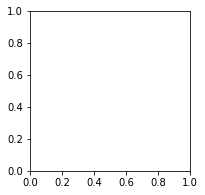

In [60]:
last_trained_epoch = 181
epochs_to_train = 1000

train(real_generator, last_trained_epoch, epochs_to_train)

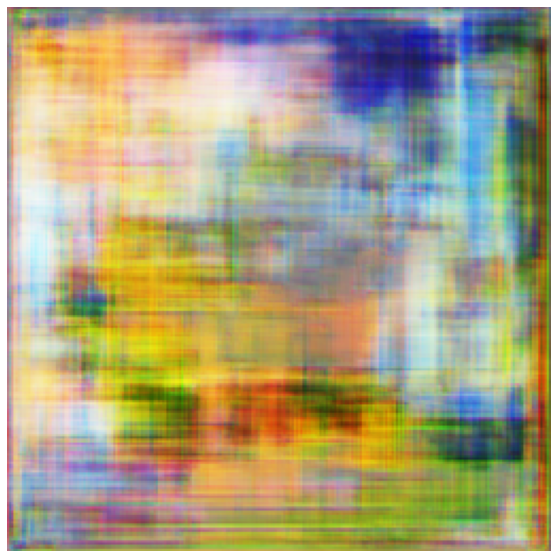

In [75]:
noise = tf.random.normal([1, 4096])
prediction = generator(noise, training=True)

plt.figure(figsize=(20, 10))
plt.imshow((prediction[0]+1)/2)
plt.axis('off')    
plt.show()

In [76]:
anim_file = '/content/gdrive/MyDrive/GAN/hands_out.gif'

In [77]:
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(out_images_path + '/image_at_epoch_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [80]:
from google.colab import files
# download the gif
files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>